<h1>Predicting Playoff Performance in NHL Teams </h1>

The aim of this project is to use a variety of player biography data available from www.nhl.com over the past 5 years and use it to predict a teams play off performance. I will categorise playoff performance into 6 categories: Did Not Qualify (DNQ), First Round, Second Round, Conf. Finals, Cup Final and Champions.  

Due to Covid ending the season early 2020 included an extra qualifying round in the playoffs. Any teams that did not progress from this round will still be counted as DNQ for the purposes of the model. 

<h2>General Imports and data loading</h2>

I need to load in each csv file, and glob them together into one big file. Then concatenate into a single dataframe and reset the index's so that I don't wind up with multiple [0,1,2,3...] indexed rows. 

In [2]:
#Standard imports
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import glob
from datetime import datetime
#Load in the regular season data and add the season column so I can better track player age
bio_files = glob.glob('Bio_Info_*.csv')

df_list= []
endYear = 2015
for filename in bio_files:
  print(filename)
  data = pd.read_csv(filename)
  data['Season'] = endYear
  df_list.append(data)
  endYear += 1

bio_data = pd.concat(df_list).reset_index() #need to add reset index, or I'll wind up with a 5 values each with the same index

#Get a summary of the data

bio_data.head()



Bio_Info_2015.csv
Bio_Info_2016.csv
Bio_Info_2017.csv
Bio_Info_2018.csv
Bio_Info_2019.csv
Bio_Info_2020.csv


,index,Player,Team,S/C,Pos,DOB,Birth City,S/P,Ctry,Ntnlty,...,Draft Yr,Round,Overall,1st Season,HOF,GP,G,A,P,Season
0,0,Justin Abdelkader,--,L,L,1987-02-25,Muskegon,MI,USA,USA,...,2005,2,42,20082009,N,5,0,2,2,2015
1,1,Karl Alzner,--,L,D,1988-09-24,Burnaby,BC,CAN,CAN,...,2007,1,5,20092010,N,14,2,2,4,2015
2,2,Joakim Andersson,--,L,C,1989-02-05,Munkedal,--,SWE,SWE,...,2007,3,88,20122013,N,7,1,1,2,2015
3,3,David Backes,ANA,R,R,1984-05-01,Minneapolis,MN,USA,USA,...,2003,2,62,20082009,N,6,1,1,2,2015
4,4,Mikael Backlund,CGY,L,C,1989-03-17,Vasteras,--,SWE,SWE,...,2007,1,24,20142015,N,11,1,1,2,2015


<h2> Define a simple age calculator </h2>

Define an age calculator and use it to append a new column to my dataframe that will the be the (current) ages of the players. I will need to be careful when using these, as this represents their ages now, not necessarily their ages during the season I am analysing. 

In [3]:
def age_calculator(DOB):
    """Take DOB as a string and returns (rough) age in years"""
    today = datetime.today()
    dob_formatted = datetime.strptime(DOB, '%Y-%m-%d') #reformat string to datetime object
    age = (today-dob_formatted)/365.25 #I'm not taking into account leap years here, but this should be fine for my purposes
    return age.days #this is actually the age in years since I divide it, but timedelta object returns it as days 

assert age_calculator("1989-10-04") == 31, "Oops. That's not my age!"

player_ages = [age_calculator(DOB) for DOB in bio_data.DOB]

bio_data['Age'] = player_ages


Now I can do a violin plot of the ages for each team across the years in question. 

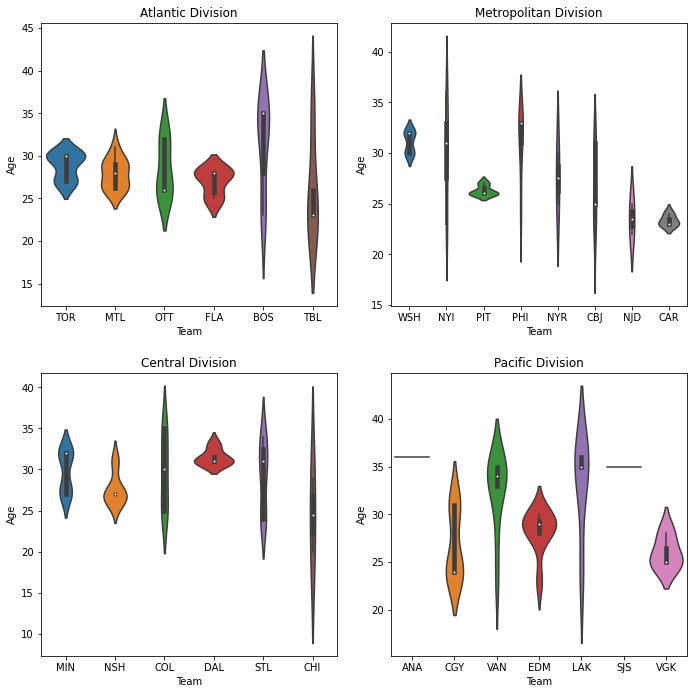

In [18]:
#Plot by division 

atl_div = ['BOS', 'TBL', 'TOR', 'FLA', 'MTL', 'BUF', 'OTT', 'DET']
met_div = ['WSH', 'PHI', 'PIT', 'CAR', 'CBJ', 'NYI', 'NYR', 'NJD']
cen_div = ['STL', 'COL', 'DAL', 'WIN', 'NSH', 'MIN', 'CHI' ]
pac_div = ['VGK', 'EDM', 'CGY', 'VAN', 'ARI', 'ANA', 'LAK', 'SJS']

atl_data = np.array([]) #initilize empty arrays
met_data = np.array([])
cen_data = np.array([])
pac_data = np.array([])
index_cnt = 0

for team in bio_data["Team"]:
    if(team in atl_div):
       atl_data = np.append(atl_data, team)
       atl_data = np.append(atl_data, int(bio_data["Age"][index_cnt]))
    elif(team in met_div):
       met_data = np.append(met_data, team)
       met_data = np.append(met_data, int(bio_data["Age"][index_cnt]))
    elif(team in cen_div):
       cen_data = np.append(cen_data, team)
       cen_data = np.append(cen_data, int(bio_data["Age"][index_cnt]))
    elif(team in pac_div):
       pac_data = np.append(pac_data, team)
       pac_data = np.append(pac_data, int(bio_data["Age"][index_cnt]))
    index_cnt += 1       

#reshape the array as it comes out as a 1D vector. Shape into Nx2 matrix 
atl_data_reshape = atl_data.reshape(int(len(atl_data)/2), 2)
met_data_reshape = met_data.reshape(int(len(met_data)/2), 2)
cen_data_reshape = cen_data.reshape(int(len(cen_data)/2), 2)
pac_data_reshape = pac_data.reshape(int(len(pac_data)/2), 2)

#convert to dataframes and cast age to int so I can plot. Comes up as a string right now for some reason
atl_df = pd.DataFrame(atl_data_reshape, columns=['Team', 'Age'])
met_df = pd.DataFrame(met_data_reshape, columns=['Team', 'Age'])
cen_df = pd.DataFrame(cen_data_reshape, columns=['Team', 'Age'])
pac_df = pd.DataFrame(pac_data_reshape, columns=['Team', 'Age'])

atl_df['Age'] = pd.to_numeric(atl_df['Age'], downcast='integer')
met_df['Age'] = pd.to_numeric(met_df['Age'], downcast='integer')
cen_df['Age'] = pd.to_numeric(cen_df['Age'], downcast='integer')
pac_df['Age'] = pd.to_numeric(pac_df['Age'], downcast='integer')

#Now I can plot them on subplots for each division
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.violinplot(x=atl_df['Team'], y=atl_df['Age'], ax=axes[0,0])
axes[0,0].title.set_text('Atlantic Division')
plt.xlabel('Team')
plt.ylabel('Age (Years)')

sns.violinplot(x=met_df['Team'], y=met_df['Age'], ax=axes[0,1])
axes[0,1].title.set_text('Metropolitan Division')

sns.violinplot(x=cen_df['Team'], y=cen_df['Age'], ax=axes[1,0])
axes[1,0].title.set_text('Central Division')

sns.violinplot(x=pac_df['Team'], y=pac_df['Age'], ax=axes[1,1])
axes[1,1].title.set_text('Pacific Division')

plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
""" Now I should create a new df with each unique player as the indices and has an age
for each season, their team for each season and their playoff performance for each season """



In [ ]:
## ----------Lets start by looking at the age of the players grouped by team and across seasons ----------- ## 

#create a dataframe of playoff performances for each team and season
playoff_df = pd.read_csv('Playoff Positions 2015-2020.csv')

#turn playoff performance into categorical
category_map = {'DNQ': 0, 'First Round': 1, 'Second Round': 2, 'Conf. Finals': 3, 
                'Cup Final': 4, 'Champions': 5}
playoff_df_cat = playoff_df.copy()
playoff_df_cat = playoff_df_cat.astype('category')

playoff_df_cat.replace(category_map, inplace=True)
playoff_df_cat = playoff_df_cat.drop(labels = 'Division', axis = 1)
playoff_df_cat_transpose = playoff_df_cat.T


years =[2015, 2016, 2017, 2018, 2019, 2020]
ax1 = plt.subplot()
sns.set(style="darkgrid")
ax1 = sns.lineplot(data = playoff_df_cat_transpose)
#create a new data frame of the ages in each season
#bio_data["Age"] = ages


#Now I can make a violin chart of the ages of players across the teams
ax = plt.subplot()
ax = sns.violinplot(x=bio_data["Team"], y=bio_data["Age"])
plt.title('Age of players across all seasons')
plt.ylabel('Age (years)')
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.show()

#Could do with more space its a bit crowded..lets try and subplot by division..

atl_div = ['BOS', 'TBL', 'TOR', 'FLA', 'MTL', 'BUF', 'OTT', 'DET']
met_div = ['WSH', 'PHI', 'PIT', 'CAR', 'CBJ', 'NYI', 'NYR', 'NJD']
cen_div = ['STL', 'COL', 'DAL', 'WIN', 'NSH', 'MIN', 'CHI' ]
pac_div = ['VGK', 'EDM', 'CGY', 'VAN', 'ARI', 'ANA', 'LAK', 'SJS']

atl_data = np.array([]) #initilize empty arrays
met_data = np.array([])
cen_data = np.array([])
pac_data = np.array([])
index_cnt = 0

for team in bio_data["Team"]:
    if(team in atl_div):
       atl_data = np.append(atl_data, team)
       atl_data = np.append(atl_data, int(bio_data["Age"][index_cnt]))
    elif(team in met_div):
       met_data = np.append(met_data, team)
       met_data = np.append(met_data, int(bio_data["Age"][index_cnt]))
    elif(team in cen_div):
       cen_data = np.append(cen_data, team)
       cen_data = np.append(cen_data, int(bio_data["Age"][index_cnt]))
    elif(team in pac_div):
       pac_data = np.append(pac_data, team)
       pac_data = np.append(pac_data, int(bio_data["Age"][index_cnt]))
    index_cnt += 1       

#reshape the array as it comes out as a 1D vector. Shape into Nx2 matrix 
atl_data_reshape = atl_data.reshape(int(len(atl_data)/2), 2)
met_data_reshape = met_data.reshape(int(len(met_data)/2), 2)
cen_data_reshape = cen_data.reshape(int(len(cen_data)/2), 2)
pac_data_reshape = pac_data.reshape(int(len(pac_data)/2), 2)

#convert to dataframes and cast age to int so I can plot. Comes up as a string right now for some reason
atl_df = pd.DataFrame(atl_data_reshape, columns=['Team', 'Age'])
met_df = pd.DataFrame(met_data_reshape, columns=['Team', 'Age'])
cen_df = pd.DataFrame(cen_data_reshape, columns=['Team', 'Age'])
pac_df = pd.DataFrame(pac_data_reshape, columns=['Team', 'Age'])

atl_df['Age'] = pd.to_numeric(atl_df['Age'], downcast='integer')
met_df['Age'] = pd.to_numeric(met_df['Age'], downcast='integer')
cen_df['Age'] = pd.to_numeric(cen_df['Age'], downcast='integer')
pac_df['Age'] = pd.to_numeric(pac_df['Age'], downcast='integer')

#Now I can plot them on subplots for each division
figure, axes = plt.subplots(nrows=2, ncols=2)

sns.violinplot(x=atl_df['Team'], y=atl_df['Age'], ax=axes[0,0])
axes[0,0].title.set_text('Atlantic Division')
plt.xlabel('Team')
plt.ylabel('Age (Years)')

sns.violinplot(x=met_df['Team'], y=met_df['Age'], ax=axes[0,1])
axes[0,1].title.set_text('Metropolitan Division')

sns.violinplot(x=cen_df['Team'], y=cen_df['Age'], ax=axes[1,0])
axes[1,0].title.set_text('Central Division')

sns.violinplot(x=pac_df['Team'], y=pac_df['Age'], ax=axes[1,1])
axes[1,1].title.set_text('Pacific Division')

plt.tight_layout(pad=2.0)
plt.show()
